In [ ]:
import os
os.chdir('..')
import geopandas as gpd
import numpy as np
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from osgeo import gdal
from glob import glob
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader


: 

In [2]:
root_code = "/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet"
root_tb_data = '/myDrive/tibet-water'

In [3]:
path_vector = root_code +  '/data/tibet/tibet_tiles_vec/tibet_tiles.gpkg'    
tiles_gdf = gpd.read_file(path_vector)
tiles_gdf.head()


,area,proj,tile_id,geometry
0,10852.910371,EPSG: 32646,001,"MULTIPOLYGON (((91.60292 25.97742, 91.60292 26..."
1,10856.066053,EPSG: 32646,002,"MULTIPOLYGON (((92.59904 25.97742, 92.59904 26..."
2,10853.222782,EPSG: 32647,003,"MULTIPOLYGON (((97.64819 25.97742, 97.64819 26..."
3,10856.025776,EPSG: 32647,004,"MULTIPOLYGON (((98.64468 25.97742, 98.64468 26..."
4,10850.995157,EPSG: 32647,005,"MULTIPOLYGON (((99.64905 25.97742, 99.64905 26..."


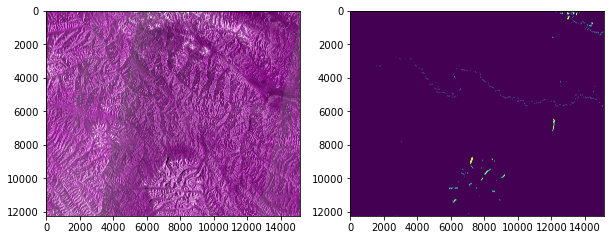

In [4]:
# ## check the prediction water map
# ## -- data path
date = '202011'
tile_id = '175'
path_s1_img = root_tb_data + '/tibet-'+date+'/s1_descend/tibet_s1des_'+date+'_tile_' + tile_id + '.tif'
path_wat = root_tb_data + '/tibet-'+date+'/s1_water/tibet_s1_'+date+'_tile_' + tile_id + '_water.tif' 

## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)
## -- data visualization
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2)
# imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2, focus_pix=[2000,4000,1000,4000])
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2)
# imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2, focus_pix=[2000,4000,1000,4000])


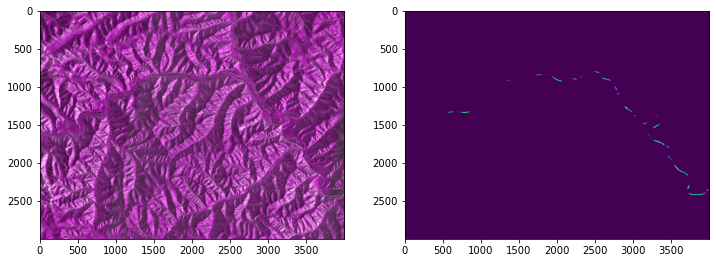

In [5]:
plt.figure(figsize=(12,8))
region = [2000,5000,1000,5000]
plt.subplot(1,2,1)
imgShow(s1_img_tile, color_bands=(0,1,0), clip_percent=2, focus_pix=region)
## plot water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, color_bands=(0,1,0), clip_percent=2, focus_pix=region)


## Remove the buffer region of the tile image

In [8]:
date = '202011'
# tile_id = '201'
for id in range(237,321):    # tile_id: 0,1,...,320; 
    tile_id = str(id+1).rjust(3,'0')
    print('tile_'+tile_id)
    path_wat = root_tb_data + '/tibet-'+date+'/s1_water/tibet_s1_'+date+'_tile_' + tile_id + '_water.tif'  # 
    path_wat_subs = root_tb_data + '/tibet-'+date+'/s1_water/tibet_s1_'+date+'_tile_' + tile_id + '_water_debuf.tif' # 
    img, img_info = readTiff(path_in=path_wat)
    idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
    tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds
    left_up = [tile_region[0],tile_region[3]]
    right_down = [tile_region[2],tile_region[1]]
    extent = str(left_up[0])+' '+str(left_up[1])+' '+str(right_down[0])+' '+str(right_down[1]) 
    # !gdal_translate -projwin $extent -co COMPRESS=LZW $path_wat $path_wat_subs
    # optional for running gdal_translate script
    command = 'gdal_translate -projwin ' + extent +' -co COMPRESS=LZW ' + path_wat + ' ' + path_wat_subs
    print(os.popen(command).read())



tile_238
Input file size is 15186, 12631
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_239
Input file size is 15331, 12521
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_240
Input file size is 15473, 12406
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_241
Input file size is 15611, 12285
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_242
Input file size is 15746, 12156
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_243
Input file size is 15132, 12666
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_244
Input file size is 15278, 12562
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_245
Input file size is 15421, 12449
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_246
Input file size is 15560, 12330
0...10...20...30...40...50...60...70...80...90...100 - done.

tile_247
Input file size is 15697, 12207
0...10...20...30...40...50...60.

## Check subseting of the image

In [8]:
## check
## -- data path
tile_id = '201'
path_s1_img = root_tb_data + '/tibet-202008/s1_ascend/tibet_s1as_202008_tile_' + tile_id + '.tif'
path_wat = root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + tile_id + '_water_subs.tif'
## -- data read
s1_img_tile, s1_img_tile_info = readTiff(path_in = path_s1_img)
s1_tile_wat, s1_tile_wat_info = readTiff(path_in = path_wat)
## -- get tile region
idx, = np.where(tiles_gdf['tile_id'].values == tile_id)
tile_region = tiles_gdf.loc[int(idx)]['geometry'].bounds



In [21]:
print(s1_tile_wat.shape)
print(type(s1_tile_wat))
print(s1_tile_wat.dtype)



(10686, 12318)
<class 'numpy.ndarray'>
uint8


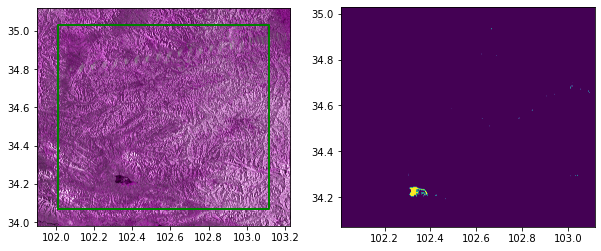

In [9]:
plt.figure(figsize=(10,5))
## plot s1 image
plt.subplot(1,2,1)
imgShow(s1_img_tile, extent=s1_img_tile_info['geoextent'], color_bands=(0,1,0), clip_percent=2)
# outline
outline_x = [tile_region[0],tile_region[2], tile_region[2], tile_region[0],tile_region[0]]  
outline_y = [tile_region[1], tile_region[1], tile_region[3], tile_region[3], tile_region[1]]
plt.plot(outline_x, outline_y, color='g', linewidth=2)
## plot subsetted water map
plt.subplot(1,2,2)
imgShow(s1_tile_wat, extent=s1_tile_wat_info['geoextent'], color_bands=(0,1,0), clip_percent=2)


## Mosaic of the surface water maps -for windows

### Downscaling (default: 10% x 10%)

In [8]:
dir_wat = root_tb_data + '/tibet-202008/s1_water'  
paths_wat = glob(dir_wat + '/*')
for path_wat in paths_wat:
  path_wat_down = path_wat.split('.')[0]+'_down.tif' 
  !gdal_translate -outsize 10% 10% -r average $path_wat $path_wat_down
  print(path_wat.split('/')[-1] + ' is downsampled successfully!')


Input file size is 12318, 10686
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_201_water_subs.tif is downsampled successfully!
Input file size is 13785, 12538
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_001_water.tif is downsampled successfully!
Input file size is 13873, 12461
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_002_water.tif is downsampled successfully!
Input file size is 13789, 12532
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_003_water.tif is downsampled successfully!
Input file size is 13876, 12457
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_004_water.tif is downsampled successfully!
Input file size is 13962, 12377
0...10...20...30...40...50...60...70...80...90...100 - done.
tibet_s1_202008_tile_005_water.tif is downsampled successfully!
Input file size is 13990, 12454
0...10...20...30...40

### Check downsampled data

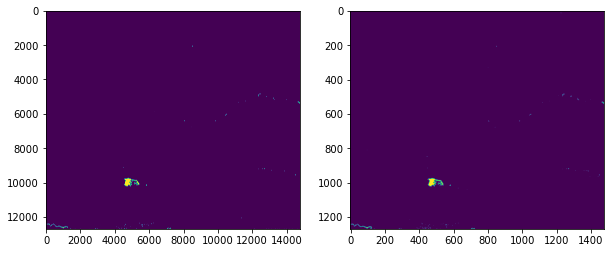

In [10]:
tile_id = 201
path_wat = root_tb_data + '/tibet-202008/s1_water/tibet_s1_202008_tile_' + str(tile_id) + '_water.tif'
path_wat_down = path_wat.split('.')[0] + '_down.tif'
wat_map,wat_map_info = readTiff(path_wat)
wat_map_down, wat_map_down_info = readTiff(path_wat_down)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(wat_map)
plt.subplot(1,2,2); plt.imshow(wat_map_down)



### Water maps mosaic

In [15]:
paths_wat_down = glob(root_tb_data + '/tibet-202008/s1_water/*_down.tif')
paths_wat_down.sort()
path_mosaic_save = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'
path_mosaic_tmp = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_tmp.tif'

for i, path_wat in enumerate(paths_wat_down):
    print('merge ->', path_wat.split('/')[-1])
    if i == 0:
      !gdal_merge.py -init 0 -o $path_mosaic_save $path_wat $path_wat
      os.rename(path_mosaic_save, path_mosaic_tmp)
    else:
      !gdal_merge.py -init 0 -o $path_mosaic_save $path_mosaic_tmp $path_wat
      if i < len(paths_wat_down)-1:
        os.rename(path_mosaic_save, path_mosaic_tmp)
os.remove(path_mosaic_tmp)



merge -> tibet_s1_202008_tile_001_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_002_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_003_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_004_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_005_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_006_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_007_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_008_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> tibet_s1_202008_tile_009_water_down.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
merge -> t

### Using shapfile to clip raster dataset.

In [18]:
tibet_shp = config.root_proj + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp' 
input_raster = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'  
output_raster= root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'  

input_raster=gdal.Open(input_path)
ds = gdal.Warp(output_path,
              input_raster,
              format = 'GTiff',
              cutlineDSName = tibet_shp,      
              cutlineWhere="FIELD = 'whatever'",
              dstNodata = 0)



### check mosaic and clip results.

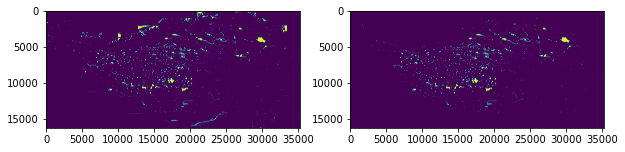

In [17]:
path_mosaic = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic.tif'
path_mosaic_clip = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'
wat_mosaic, wat_mosaic_info = readTiff(path_mosaic)
wat_mosaic_clip, wat_mosaic_clip_info = readTiff(path_mosaic_clip)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(wat_mosaic)
plt.subplot(1,2,2)
plt.imshow(wat_mosaic_clip)


Dispaly image using cartopy package.

In [3]:
# 0. data input
tibet_shp = root_code + '/data/tibet/tibet-plateau-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp' 
path_watermap = root_tb_data + '/tibet-202008/s1_water/water_map_down_mosaic_clip.tif'
water_map, img_info = readTiff(path_in = path_watermap)


In [24]:
# fig = plt.figure(figsize=(10, 10))
# plt.imshow(water_map, extent=img_info['geoextent'], \
#                           vmin=1, vmax=1,
#                           alpha=1, interpolation='none', \
#                           cmap=cmap_water, 
#                           zorder=1)



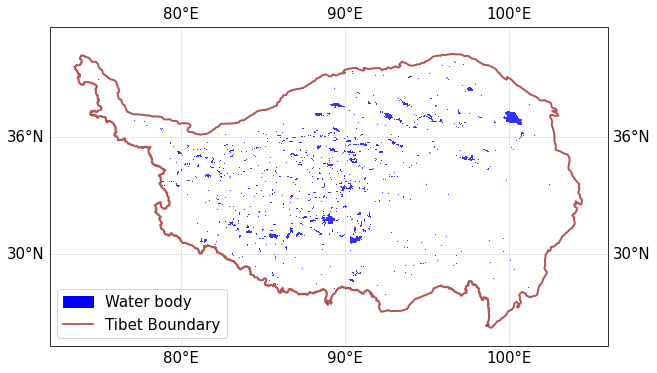

In [4]:
cmap_water = LinearSegmentedColormap.from_list('linear color', ["Blue", 'Blue'])

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([72, 106, 25.0, 40.0])
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, 
                         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')   

gl.xlocator = mticker.MultipleLocator(10)  # Adjust the interval of ticks
gl.ylocator = mticker.MultipleLocator(6)

# 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(tibet_shp).geometries(), \
                              crs=ccrs.PlateCarree(), edgecolor='Brown', alpha=0.8, \
                              linestyle='-', linewidth=2, facecolor='none')
ax.add_feature(shp_fea, zorder=2) 

# ## 2. water result
water_map = np.ma.masked_where(water_map == 0, water_map).astype(np.float32).filled(np.nan)
ax_water = ax.imshow(water_map, extent=img_info['geoextent'], \
                                vmin=1, vmax=1,
                                alpha=0.8, interpolation='none', \
                                transform=ccrs.PlateCarree(),   ## time-consuming
                                cmap=cmap_water, 
                                zorder=1)

# 3. Legend
water_patch = mpatches.Patch(color='Blue', label='Water body')
tibet_line = mlines.Line2D([], [], color='Brown', linestyle ='-',
                          linewidth=1.5, label='Tibet Boundary')
plt.legend(handles=[water_patch,tibet_line], loc='lower left')

# plt.savefig(config.root_proj + '/figure/study_area.png', bbox_inches='tight')
# plt.show()
